# Convert Raster Data to DGGS Zones


⚠️ Below code requires https://github.com/allixender/dggrid4py/pull/26 (i.e.: `DGGRIDv8`) to resolve DGGRID system indexing issues.

⚠️ Requires `dggrid4py` version `0.5.2` or later to include fixes for:

- https://github.com/allixender/dggrid4py/pull/26 and https://github.com/allixender/dggrid4py/pull/27 to also inject the origin vertex orientation parameters.
  `DGGRID` defaults are not aligned (see https://github.com/LandscapeGeoinformatics/pydggsapi/issues/11#issuecomment-3356387170).

  ```python
  dggs_orient_specify_type SPECIFIED
  dggs_vert0_lon 11.20
  dggs_vert0_lat 58.282525588538994675786
  dggs_vert0_azimuth 0.0
  ```

- https://github.com/allixender/dggrid4py/issues/28 to provide authalic-to-geodetic latitude conversion
  (see implementation in https://github.com/allixender/dggrid4py/commit/84eaf5eacfcd645fad9e45b0f5bb69cd79c715c1)

⚠️ Any clipping AOI in WGS84 must be pre-converted to authalic latitudes from geodetic before invoking DGGRID.
The resulting geometries (the DGGS zones) must also be converted back to geodetic latitudes after DGGRID operations.

![DGGRID-authalic-geodetic](DGGRID-authalic-geodetic-check.png)
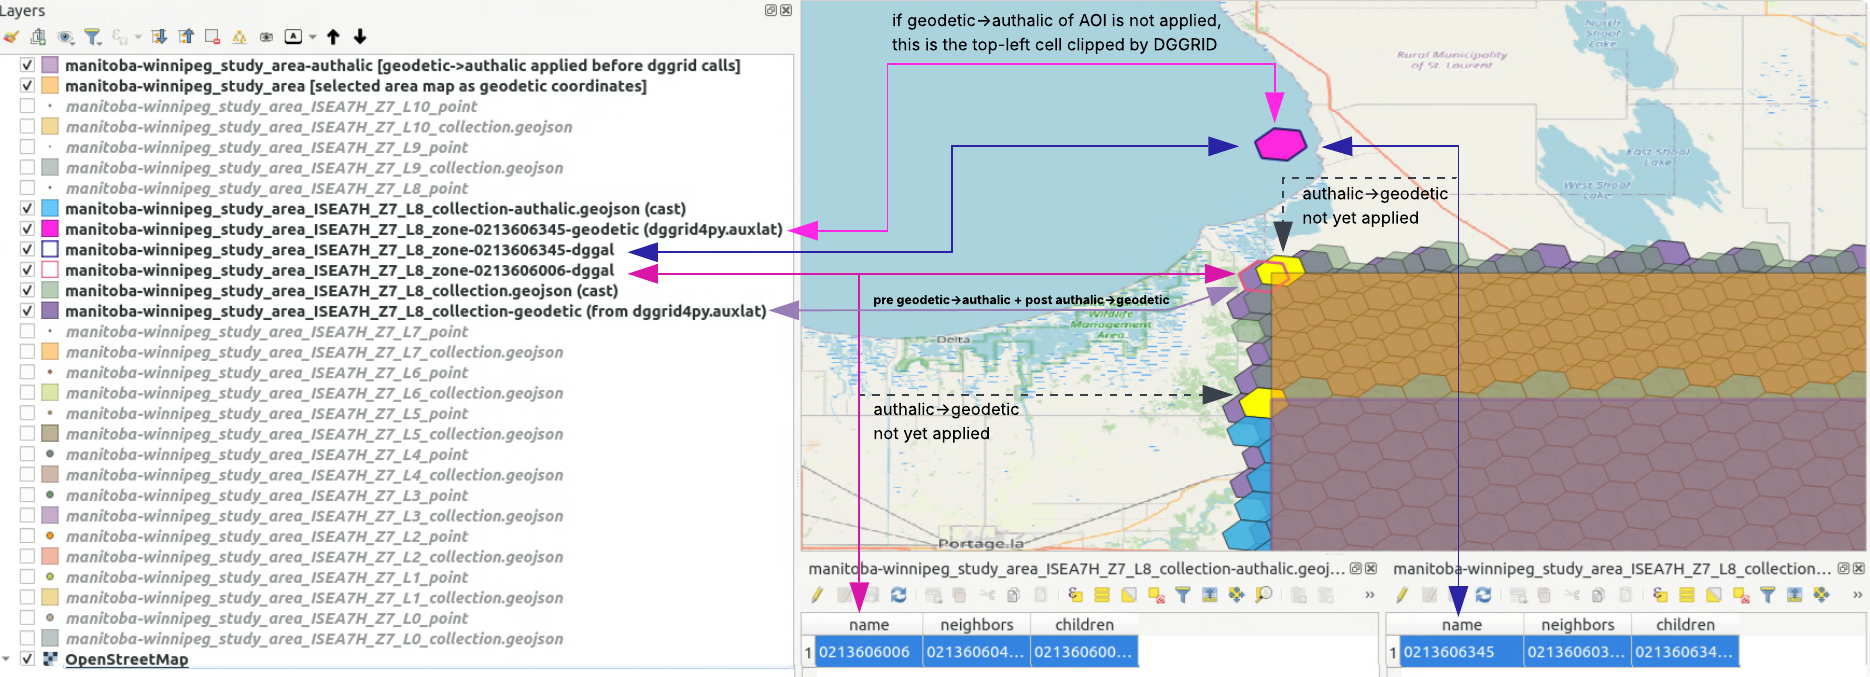

In [22]:
import os
import warnings
from typing import Any

import datetime
import folium
import json
import pystac_client
import dggrid4py
import geopandas as gpd
import numpy as np
import shapely
import rasterio as rio
from dggrid4py.auxlat import geoseries_to_authalic, geoseries_to_geodetic
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm.autonotebook import tqdm

from vgrid.conversion.dggs2geo.dggrid2geo import dggrid2geo
from vgrid.conversion.raster2dggs import raster2a5, raster2dggrid, raster2rhealpix, raster2h3
from vgrid.conversion.raster2dggs.raster2dggrid import get_nearest_dggrid_resolution
from vgrid.conversion.latlon2dggs import latlon2dggrid
from vgrid.utils.geometry import geodesic_dggs_metrics
from vgrid.utils.io import (
    convert_to_output_format,
    create_dggrid_instance,
    download_file,
    validate_dggrid_type,
    validate_dggrid_resolution,
)

In [23]:
# [optional] extra dependencies for nicer notebook progress bars if not available
!pip install -U tqdm ipywidgets jupyterlab_widgets

## Identify the Study Area of Interest

In [24]:
with open("../manitoba-winnipeg_study_area/inputs/manitoba-winnipeg_study_area.geojson") as f:
    data = f.read()
    poly = json.loads(data)
    geom = shapely.from_geojson(data)

geom.bounds

(-98.0, 49.0, -96.5, 50.25)

In [25]:
map = folium.Map(location=[geom.centroid.y, geom.centroid.x], zoom_start=8)
folium.GeoJson(poly).add_to(map)
map

## Find RCM ARD Data from EODMS matching AOI

In [26]:
client = pystac_client.Client.open("https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/")
result = client.search(
    collections=["rcm-ard"],
    intersects=geom,
    datetime=[
        "2018-01-01", #"2025-09-01",
        "2026-01-01",
    ],
    sortby=[
        {"field": "properties.datetime", "direction": "desc"},
    ],
    # FIXME: if the number of matched items exceeds this limit, the next pages might fail on EODMS STAC
    #   (see https://github.com/stac-utils/pystac-client/issues/850)
    #   Use a larger quantity in the meantime to return everything all at once, since the total number of items remain lower than the upper limit (100000).
    limit=1000,
)
result.matched()

116

In [27]:
item = next(result.items())
item

<Item id=f87860d1-b9ac-4150-afcf-7671697cbf61>

## Define DGGRID Instance


In [28]:
DGGRID_EXE = os.getenv("DGGRID_EXE", "../../DGGRID/build/src/apps/dggrid/dggrid")
# dggrid_instance = create_dggrid_instance(DGGRID_EXE) # FIX: create ourselves to avoid legacy errors and add GDAL support
dggrid_instance = dggrid4py.DGGRIDv8(
    executable=DGGRID_EXE,
    working_dir='.',
    capture_logs=True,
    has_gdal=True,
    tmp_geo_out_legacy=False,
    silent=False,
    debug=False,
)

#### Utility Functions

In [29]:
def raster_reproject(raster_path: os.PathLike, dst_crs: str = "EPSG:4326") -> os.PathLike:
    reproject_name, reproject_ext = os.path.splitext(os.path.basename(raster_path))
    reproject_name = f"{reproject_name}_{dst_crs.replace(':', '')}"
    reproject_path = os.path.join(os.path.dirname(raster_path), f"{reproject_name}{reproject_ext}")
    if os.path.isfile(reproject_path):
        return reproject_path

    with rio.open(raster_path) as src:
        if src.crs == dst_crs:
            return raster_path

        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        dst_meta = src.meta.copy()
        dst_meta.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
            # Cloud-Optimized GeoTIFF (COG) creation options
            "interleave": "pixel",
            "compress": "DEFLATE",
            "tiled": True,
            "blockxsize": 512,
            "blockysize": 512,
        })
        with rio.open(reproject_path, 'w', **dst_meta) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )
    return reproject_path


def build_overviews(raster_path: os.PathLike, overviews: list[int] = None):
    overviews = overviews or [2, 4, 8, 16, 32]
    with rio.open(raster_path, "r+") as src:
        src.build_overviews(overviews, Resampling.nearest)
        src.update_tags(ns="rio_overview", resampling="nearest")


def raster2dggs_custom(
    dggrid_instance: "dggrid4py.DGGRID",
    dggs_type: str,
    raster_path: os.PathLike,
    resolution: int | None = None,
    output_format: str = "gpd",
    output_cell_path: str | None = None,  # raster path by default if not specified
    output_cell_data: bool = True,
    extra_properties: dict[str, Any] = None,
    dggs_zones_path: os.PathLike | None = None,
    **output_kwargs,
) -> gpd.GeoDataFrame | None:

    dggs_type = validate_dggrid_type(dggs_type)
    raster_path = raster_reproject(raster_path)  # pre-reproject to reduce time for each iter of dggrid
    output_cell_path = output_cell_path or os.path.dirname(raster_path)
    os.makedirs(output_cell_path, exist_ok=True)
    extra_properties = extra_properties or {}

    # Auto-select resolution if not provided
    if resolution is None:
        cell_size, resolution = get_nearest_dggrid_resolution(dggrid_instance, dggs_type, raster_path)
        print(f"Cell size: {cell_size} m2")
        print(f"Nearest {dggs_type.upper()} resolution determined: {resolution}")
    else:
        resolution = validate_dggrid_resolution(dggs_type, resolution)

    if output_cell_data:
        # FIXME: any advantage to use overviews over computing statistics over raw high-res data directly?
        #   At the very least, create them when cell output data is requested
        build_overviews(raster_path)

    # Open the raster file to get metadata and data
    src = rio.open(raster_path)

    # collect cells
    # NOTE:
    #   Although we can reduce the grid area with raster/DGGS/AOI intersection,
    #   calculating the DGGRS zones is what takes the longest time (especially at high resolutions).
    #   Therefore, reuse a cached DGGRS of all candidates over the entire AOI,
    #   and ignore empty cells data due to no overlapping raster pixels.
    #   This approach as the added advantage that, due to static DGGS/AOI geometry,
    #   we can avoid re-download of the raster data (to save space) by directly iterating
    #   over all DGGS resolutions for one raster at a time.
    #   When using the cached 'dggs_zones_path' approach with constant DGGS zones over AOI,
    #   it is faster to compute the all resolutions over the STAC Item to take advantage
    #   of the cache on next iterations, even if more zones are computed than needed.
    #   If instead using the raster-specific extent to reduce the AOI by their intersection,
    #   then each iteration must do its own operation (no cache). This is negligible at low
    #   resolutions, but becomes significant at high resolutions.
    raster_geom = shapely.geometry.box(*list(src.bounds))
    if dggs_zones_path and os.path.isfile(dggs_zones_path):
        cells = read_vector_file(dggs_zones_path)
        aoi_geom = geom  # only the overall AOI
    else:
        if not dggs_zones_path:
            # previous approach that recomputes for each raster/DGGS/AOI intersection
            aoi_geom = shapely.intersection(raster_geom, geom)
        else:
            aoi_geom = geom  # only the overall AOI
        if aoi_geom.geom_type == "GeometryCollection":
            aoi_geom = shapely.unary_union([g for g in aoi_geom.geoms if g.geom_type in ["Polygon", "MultiPolygon"]])
        if aoi_geom.is_empty:
            raise ValueError("Invalid empty AOI geometry.")
        if aoi_geom.geom_type != "Polygon":
            raise ValueError(f"Invalid AOI geometry type: {aoi_geom.geom_type}.")
        aoi_geom = geoseries_to_authalic(gpd.GeoSeries(aoi_geom))[0]
        cells = dggrid_instance.grid_cell_polygons_for_extent(
            dggs_type,
            resolution=resolution,
            clip_geom=aoi_geom,
            **output_kwargs
        )
        cells.geometry = geoseries_to_geodetic(cells.geometry)
        if dggs_zones_path:  # cache for next iteration
            save_vector_file(cells, dggs_zones_path)
    cell_count = len(cells)
    print(f"Matched cells: {cell_count} (res={resolution}) in {aoi_geom}")

    properties = []

    # Collect band values during the pixel scan, storing the first sample per DGGRID cell
    for cell in tqdm(
        cells.itertuples(index=False),
        desc="Converting raster to DGGRID",
        unit=" cells",
        total=cell_count,
    ):
        cell_id = cell.name if hasattr(cell, "name") else cell.global_id
        cell_geom = cell.geometry
        try:
            cell_data, cell_transform = mask(src, [cell_geom], crop=True)
        except ValueError:
            continue  # skip empty cells (geom does not overlap raster)
        cell_meta = src.meta.copy()
        cell_meta.update({
            "driver": "GTiff",
            "transform": cell_transform,
            "crs": src.crs,
            "height": cell_data.shape[1],
            "width": cell_data.shape[2],
            # Cloud-Optimized GeoTIFF (COG) creation options
            "interleave": "pixel",
            "compress": "DEFLATE",
            "tiled": True,
            "blockxsize": 512,
            "blockysize": 512,
        })

        cell_valid_data = cell_data[cell_data != src.nodata]
        if len(cell_valid_data) == 0:
            continue  # skip empty cells

        if output_cell_data:
            output_cell_file = os.path.join(output_cell_path, f"cell-{cell_id}.tif")
            with rio.open(output_cell_file, "w", **cell_meta) as cell_f:
                cell_f.write(cell_data)

        cell_mean = np.mean(cell_valid_data)
        cell_stddev = np.std(cell_valid_data)
        cell_median = np.median(cell_valid_data)
        cell_minimum = np.min(cell_valid_data)
        cell_maximum = np.max(cell_valid_data)
        cell_pixel_count = len(cell_valid_data)

        # Build GeoDataFrame as the base
        try:
            # Get cell metrics
            centroid_lat, centroid_lon, avg_edge_len, cell_area, cell_perimeter = geodesic_dggs_metrics(
                cell_geom, len(cell_geom.exterior.coords) - 1
            )
            cell_props = {
                f"dggrid_{dggs_type}": cell_id,
                "resolution": resolution,
                **extra_properties,
            }
            cell_props.update({
                "center_lat": centroid_lat,
                "center_lon": centroid_lon,
                "avg_edge_len": avg_edge_len,
                "cell_area": cell_area,
                "cell_perimeter": cell_perimeter,
                "cell_minimum": cell_minimum,
                "cell_maximum": cell_maximum,
                "cell_mean": cell_mean,
                "cell_median": cell_median,
                "cell_stddev": cell_stddev,
                "cell_pixel_count": cell_pixel_count,
                "geometry": cell_geom,
            })
            properties.append(cell_props)
        except Exception:
            continue

    src.close()

    if not properties:
        warnings.warn("No DGGRID cells found overlapping the raster data.", RuntimeWarning)
        return None

    # Build GeoDataFrame
    gdf = gpd.GeoDataFrame(properties, geometry="geometry", crs="EPSG:4326")

    # Use centralized output utility
    base_name = os.path.splitext(os.path.basename(raster_path))[0]
    output_name = f"{base_name}2dggrid" if output_format is not None else None
    return convert_to_output_format(gdf, output_format, output_name)


def ensure_timezone_utc(dt_str: str) -> str:
    try:
        dt = datetime.datetime.fromisoformat(dt_str.replace("Z", "+00:00"))
        dt_utc = dt.astimezone(datetime.timezone.utc)
        if dt_utc.microsecond:
            return dt_utc.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + "Z"
        return dt_utc.strftime("%Y-%m-%dT%H:%M:%SZ")
    except Exception:
        # Fallback: append Z if no timezone info
        if not dt_str.endswith("Z"):
            return dt_str + "Z"
        return dt_str


def read_vector_file(file_path: os.PathLike) -> gpd.GeoDataFrame:
    file_path = str(file_path)
    if file_path.endswith(".parquet"):
        return gpd.read_parquet(file_path)
    elif file_path.endswith(".ftr"):
        return gpd.read_feather(file_path)
    return gpd.read_file(file_path)


def save_vector_file(data: gpd.GeoDataFrame, output_path: os.PathLike):
    output_path = str(output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    if output_path.endswith(".parquet"):
        data.to_parquet(output_path)
    elif output_path.endswith(".ftr"):
        data.to_feather(output_path)
    else:
        data.to_file(output_path)


In [30]:
# patch command to avoid massive outputs by underlying tools
import mock
import sys
import types
import tqdm as tqdm_module

tqdm_patched = types.ModuleType("tqdm")
tqdm_patched.tqdm = tqdm_module.autonotebook.tqdm

## Convert RCM ARD Data to DGGS

#### NOTE

⚠️ Requires patch: https://github.com/opengeoshub/vgrid/pull/57 if running the `vgrid` "raster2..." native operations
on non-geometric CRS (i.e.: PROJCRS) rasters.


In [32]:
output_cell_stats_formats = ["parquet"]  # "geojson" can be used for visualization, but slow and large duplicates for big datasets
output_cell_data_format = ".tif"
output_base_dir = "./outputs/manitoba_rcm_ard"
output_bands = ["rr", "rl"]
dggs_types_res = [
    # ("H3", lambda: _src, _res, _out_fmt, **__: raster2h3(_src, _res, _out_fmt), [7, 8]),  # H3 L8 hexagon dimension ~= ISEA7H L9
    # ("A5", lambda: _src, _res, _out_fmt, **__: raster2a5(_src, _res, _out_fmt), [9]),
    # ("rHEALPix", lambda: _src, _res, _out_fmt, **__: raster2rhealpix(_src, _res, _out_fmt), [8, 9]),
    # NOTE: raster2dggrid
    #   wrapper dispatches to the underlying "dggrid" tool that provide additional DGGRS
    #   IGEO7 = ISEA7H with 7Z address representation (https://dggrid4py.readthedocs.io/en/latest/usage.html)
    # WARNING:
    #   use dggrid BIN_POINT_VALS directly or another custom method instead of 'raster2dggrid'
    #   raster2dggrid is very slow since it computes every lat/lon=>cellId for every (x,y) pixel sequentially
    #   it also reprojects each of those (lat,lon) coordinates one by one
    #   raster2dggrid also incorrectly picks any first cellId match and drops all other values within that same cell
    #   depending on the cell size/resolution, this first value might not be representative at all!
    # (
    #     "IGEO7",
    #     lambda *_, **__: raster2dggrid(dggrid_instance, "IGEO7", *_, dggrid_input_address_type="Z7_STRING", **__),
    #     [8, 9]
    # ),
    (
        "IGEO7",
        lambda *_, **__: raster2dggs_custom(
            dggrid_instance,
            "ISEA7H",
            *_,
            # WARNING: following requires new DGGRID v8
            #dggrid_output_address_type="Z7_STRING",
            output_cell_label_type="OUTPUT_ADDRESS_TYPE",
            output_address_type="HIERNDX",
            output_hier_ndx_system="Z7",
            output_hier_ndx_form="DIGIT_STRING",
            # WARNING: following requires dggrid4py >0.5.0-dev
            # NOTE: using strings to keep precision
            dggs_vert0_lon="11.20",
            dggs_vert0_lat="58.282525588538994675786",
            dggs_vert0_azimuth="0.0",
            dggs_orient_specify_type="SPECIFIED",
            geodetic_densify=0.01,
            densification=5,
            clip_cell_densification=3,
            **__,
        ),
        *zip(*
            # pre-computed res=14 (~10m) closest to ~20m rasters retrieved from STAC
            # for each resolution, should it output zone data (GeoTIFF) along with statistics?
            {
                0: False,       # ~8,200km
                1: False,       # ~3,053km
                2: False,       # ~1,152km
                3: False,       # ~435.2km
                4: False,       # ~164.5km
                5: True,        # ~62.16km
                6: False,       # ~23.49km
                7: False,       # ~8.880km
                8: False,       # ~3.356km
                9: False,       # ~1.268km
                10: True,       # ~479m
                # 11: False,    # ~181m
                # 12: False,    # ~68m
                # 13: False,    # ~25m
                # 14: False,    # ~10m
                # 15: False,    # ~3.7m
                # ...
            }.items()
        )
    ),
]

dggs_bar = tqdm(dggs_types_res, desc="Processing DGGS Types")
for dggrs_operations in dggs_bar:
    dggrs, dggrs_builder, dggrs_resolutions = dggrs_operations[:3]
    dggrs_output_cell_data = [False] * len(dggrs_resolutions) if len(dggrs_operations) < 4 else dggrs_operations[3]
    dggs_bar.set_postfix(dggrs=dggrs)

    stac_items_bar = tqdm(result.items(), desc="Processing STAC Items", leave=False, total=result.matched())
    for item in stac_items_bar:
        # backup source for later cross-reference
        date_time = ensure_timezone_utc(item.properties["datetime"])
        date = item.properties["datetime"][:10]  # YYYY-MM-DD
        stac_item_dir = os.path.join(output_base_dir, "src", date)
        stac_item_path = os.path.join(stac_item_dir, f"stac_item_{item.id}.geojson")
        os.makedirs(stac_item_dir, exist_ok=True)
        with open(stac_item_path, mode="w", encoding="utf-8") as f:
            json.dump(item.to_dict(), f, indent=2)
        stac_items_bar.set_postfix(dggrs=dggrs, item=f"{item.id}", date=date)

        for band in output_bands:

            src_uri = item.assets[band].href
            src_name = os.path.basename(src_uri)
            src_dir = os.path.join(stac_item_dir, band)
            src_path = os.path.join(src_dir, src_name)

            res_bar = tqdm(
                zip(dggrs_resolutions, dggrs_output_cell_data),
                desc="Processing Resolutions",
                leave=False,
                total=len(dggrs_resolutions),
            )
            for resolution, output_cell_data in res_bar:
                res_bar.set_postfix(dggrs=dggrs, resolution=resolution, asset=src_name)

                dggs_res_path = os.path.join(output_base_dir, dggrs, f"L{resolution}")
                dggs_zones_path = os.path.join(dggs_res_path, f"dggs_zones_{dggrs}_L{resolution}.parquet")

                out_dir = os.path.join(dggs_res_path, date, band)
                os.makedirs(out_dir, exist_ok=True)
                out_files = {
                    fmt: os.path.join(out_dir, f"{os.path.splitext(src_name)[0]}.{fmt}")
                    for fmt in output_cell_stats_formats
                }
                err_file = os.path.join(out_dir, f"{os.path.splitext(src_name)[0]}.err")
                if os.path.isfile(err_file):
                    print(f"  Skipping... Previous error detected during cell generation: {err_file}")
                    continue
                if all(os.path.isfile(p) for p in out_files.values()):
                    print(f"  Skipping... All output files already exist: {list(out_files.values())}")
                    continue

                print(f"Converting to {dggrs}-L{resolution} [band={band}]. Saving to [{out_dir}]...")
                if not os.path.isfile(src_path):
                    os.makedirs(src_dir, exist_ok=True)
                    with mock.patch.dict(sys.modules, {"tqdm": tqdm_patched}):
                        download_file(src_uri, src_path)
                out_df = dggrs_builder(
                    src_path,
                    resolution=resolution,
                    dggs_zones_path=dggs_zones_path,
                    output_format="gpd",  # GeoPandas Dataframe
                    output_cell_path=out_dir,  # only custom function
                    output_cell_data=output_cell_data,  # only custom function
                    extra_properties={  # only custom function
                        "datetime": date_time,
                        "day": date,
                    }
                )

                # skip for next time
                if out_df is None:
                    with open(err_file, "a"):
                        os.utime(err_file, None)
                    warnings.warn(
                        f"No DGGRID cells found overlapping the raster data. Writing skip file: {err_file}",
                        RuntimeWarning,
                    )
                    continue

                # save results
                for fmt, out_path in out_files.items():
                    convert_to_output_format(out_df, output_format=fmt, output_name=out_path)

            # cleanup to save space
            if os.path.isfile(src_path):
                os.remove(src_path)
            reproject_path = src_path.replace(".tif", "_EPSG4326.tif")
            if os.path.isfile(reproject_path):
                os.remove(reproject_path)

Processing DGGS Types:   0%|          | 0/1 [00:00<?, ?it/s]

Processing STAC Items:   0%|          | 0/116 [00:00<?, ?it/s]

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-09/rr/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-09/rr/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-09/rr/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-09/rr/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-09/rr/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-09/rr/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-09/rl/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-09/rl/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-09/rl/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-09/rl/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-09/rl/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-09/rl/RCM3_OK3685761_PK3896398_1_SC30MCPB_20251109_001408_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-08/rr/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-08/rr/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-08/rr/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-08/rr/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-08/rr/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-08/rr/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-08/rl/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-08/rl/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-08/rl/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-08/rl/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-08/rl/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-08/rl/RCM3_OK3685761_PK3894960_1_SC30MCPA_20251108_000623_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-07/rr/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-07/rr/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-07/rr/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-07/rr/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-07/rr/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-07/rr/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-07/rl/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-07/rl/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-07/rl/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-07/rl/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-07/rl/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-07/rl/RCM1_OK3685761_PK3894220_1_SC30MCPD_20251107_123948_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-06/rr/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-06/rr/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-06/rr/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-06/rr/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-06/rr/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-06/rr/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-11-06/rl/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-11-06/rl/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-11-06/rl/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-11-06/rl/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-11-06/rl/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-11-06/rl/RCM1_OK3685761_PK3892538_3_SC30MCPD_20251106_123046_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-31/rr/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-31/rr/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-31/rr/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-31/rr/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-31/rr/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-31/rr/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-31/rl/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-31/rl/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-31/rl/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-31/rl/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-31/rl/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-31/rl/RCM1_OK3685761_PK3882656_1_SC30MCPB_20251031_000606_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-29/rr/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-29/rr/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-29/rr/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-29/rr/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-29/rr/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-29/rr/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-29/rl/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-29/rl/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-29/rl/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-29/rl/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-29/rl/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-29/rl/RCM3_OK3685761_PK3879267_1_SC30MCPD_20251029_002226_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-28/rr/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-28/rr/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-28/rr/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-28/rr/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-28/rr/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-28/rr/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-28/rl/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-28/rl/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-28/rl/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-28/rl/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-28/rl/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-28/rl/RCM3_OK3685761_PK3877150_1_SC30MCPB_20251028_001420_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-26/rr/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-26/rr/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-26/rr/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-26/rr/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-26/rr/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-26/rr/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-26/rl/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-26/rl/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-26/rl/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-26/rl/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-26/rl/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-26/rl/RCM1_OK3685761_PK3874721_1_SC30MCPD_20251026_123949_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-26/rr/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-26/rr/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-26/rr/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-26/rr/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-26/rr/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-26/rr/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-26/rl/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-26/rl/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-26/rl/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-26/rl/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-26/rl/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-26/rl/RCM1_OK3685761_PK3874718_2_SC30MCPD_20251026_123901_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-25/rr/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-25/rr/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-25/rr/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-25/rr/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-25/rr/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-25/rr/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-25/rl/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-25/rl/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-25/rl/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-25/rl/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-25/rl/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-25/rl/RCM1_OK3685761_PK3873264_4_SC30MCPD_20251025_122949_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-19/rr/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-19/rr/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-19/rr/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-19/rr/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-19/rr/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-19/rr/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-19/rl/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-19/rl/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-19/rl/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-19/rl/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-19/rl/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-19/rl/RCM1_OK3685761_PK3863177_1_SC30MCPA_20251019_000546_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-18/rr/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-18/rr/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-18/rr/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-18/rr/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-18/rr/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-18/rr/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-18/rl/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-18/rl/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-18/rl/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-18/rl/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-18/rl/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-18/rl/RCM2_OK3685761_PK3862248_1_SC30MCPC_20251018_123936_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-17/rr/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-17/rr/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-17/rr/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-17/rr/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-17/rr/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-17/rr/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-17/rl/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-17/rl/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-17/rl/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-17/rl/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-17/rl/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-17/rl/RCM3_OK3685761_PK3859862_1_SC30MCPD_20251017_002226_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-17/rr/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-17/rr/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-17/rr/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-17/rr/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-17/rr/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-17/rr/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-17/rl/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-17/rl/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-17/rl/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-17/rl/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-17/rl/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-17/rl/RCM3_OK3685761_PK3859860_1_SC30MCPD_20251017_002212_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-16/rr/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-16/rr/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-16/rr/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-16/rr/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-16/rr/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-16/rr/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-16/rl/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-16/rl/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-16/rl/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-16/rl/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-16/rl/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-16/rl/RCM3_OK3685761_PK3858269_1_SC30MCPB_20251016_001421_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-14/rr/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-14/rr/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-14/rr/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-14/rr/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-14/rr/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-14/rr/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-14/rl/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-14/rl/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-14/rl/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-14/rl/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-14/rl/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-14/rl/RCM1_OK3685761_PK3855904_1_SC30MCPD_20251014_123949_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-14/rr/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-14/rr/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-14/rr/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-14/rr/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-14/rr/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-14/rr/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-14/rl/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-14/rl/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-14/rl/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-14/rl/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-14/rl/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-14/rl/RCM1_OK3685761_PK3855901_2_SC30MCPD_20251014_123901_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-13/rr/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-13/rr/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-13/rr/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-13/rr/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-13/rr/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-13/rr/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-13/rl/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-13/rl/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-13/rl/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-13/rl/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-13/rl/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-13/rl/RCM1_OK3685761_PK3854404_3_SC30MCPD_20251013_123043_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-07/rr/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-07/rr/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-07/rr/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-07/rr/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-07/rr/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-07/rr/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-07/rl/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-07/rl/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-07/rl/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-07/rl/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-07/rl/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-07/rl/RCM2_OK3685761_PK3844300_1_SC30MCPC_20251007_124751_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-07/rr/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-07/rr/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-07/rr/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-07/rr/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-07/rr/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-07/rr/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-07/rl/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-07/rl/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-07/rl/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-07/rl/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-07/rl/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-07/rl/RCM1_OK3685761_PK3843295_1_SC30MCPB_20251007_000607_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-05/rr/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-05/rr/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-05/rr/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-05/rr/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-05/rr/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-05/rr/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-05/rl/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-05/rl/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-05/rl/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-05/rl/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-05/rl/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-05/rl/RCM3_OK3685761_PK3839903_1_SC30MCPC_20251005_002226_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-05/rr/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-05/rr/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-05/rr/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-05/rr/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-05/rr/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-05/rr/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-05/rl/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-05/rl/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-05/rl/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-05/rl/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-05/rl/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-05/rl/RCM3_OK3685761_PK3839898_1_SC30MCPD_20251005_002205_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-04/rr/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-04/rr/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-04/rr/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-04/rr/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-04/rr/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-04/rr/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-04/rl/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-04/rl/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-04/rl/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-04/rl/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-04/rl/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-04/rl/RCM1_OK3685761_PK3839097_1_SC30MCPA_20251004_125540_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-02/rr/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-02/rr/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-02/rr/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-02/rr/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-02/rr/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-02/rr/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-02/rl/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-02/rl/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-02/rl/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-02/rl/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-02/rl/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-02/rl/RCM1_OK3685761_PK3835628_1_SC30MCPD_20251002_123958_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-02/rr/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-02/rr/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-02/rr/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-02/rr/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-02/rr/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-02/rr/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-02/rl/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-02/rl/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-02/rl/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-02/rl/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-02/rl/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-02/rl/RCM1_OK3685761_PK3835626_2_SC30MCPD_20251002_123901_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-01/rr/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-01/rr/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-01/rr/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-01/rr/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-01/rr/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-01/rr/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-01/rl/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-01/rl/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-01/rl/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-01/rl/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-01/rl/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-01/rl/RCM1_OK3685761_PK3834300_5_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-01/rr/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-01/rr/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-01/rr/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-01/rr/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-01/rr/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-01/rr/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-10-01/rl/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-10-01/rl/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-10-01/rl/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-10-01/rl/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-10-01/rl/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-10-01/rl/RCM1_OK3685761_PK3834300_4_SC30MCPD_20251001_122949_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-16/rr/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-16/rr/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-16/rr/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-16/rr/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-16/rr/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-16/rr/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-16/rl/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-16/rl/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-16/rl/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-16/rl/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-16/rl/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-16/rl/RCM3_OK3556292_PK3810344_1_SC30MCPD_20250916_123959_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-13/rr/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-13/rr/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-13/rr/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-13/rr/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-13/rr/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-13/rr/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-13/rl/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-13/rl/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-13/rl/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-13/rl/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-13/rl/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-13/rl/RCM2_OK3556292_PK3804068_2_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-13/rr/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-13/rr/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-13/rr/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-13/rr/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-13/rr/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-13/rr/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-13/rl/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-13/rl/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-13/rl/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-13/rl/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-13/rl/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-13/rl/RCM2_OK3555385_PK3804066_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-13/rr/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-13/rr/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-13/rr/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-13/rr/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-13/rr/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-13/rr/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-13/rl/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-13/rl/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-13/rl/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-13/rl/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-13/rl/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-13/rl/RCM2_OK3556292_PK3804068_1_SC30MCPB_20250913_124733_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-12/rr/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-12/rr/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-12/rr/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-12/rr/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-12/rr/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-12/rr/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-12/rl/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-12/rl/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-12/rl/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-12/rl/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-12/rl/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-12/rl/RCM2_OK3555385_PK3799673_1_SC30MCPD_20250912_123915_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-11/rr/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-11/rr/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-11/rr/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-11/rr/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-11/rr/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-11/rr/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-11/rl/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-11/rl/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-11/rl/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-11/rl/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-11/rl/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-11/rl/RCM2_OK3556292_PK3797550_5_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-11/rr/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-11/rr/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-11/rr/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-11/rr/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-11/rr/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-11/rr/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-11/rl/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-11/rl/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-11/rl/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-11/rl/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-11/rl/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-11/rl/RCM2_OK3556292_PK3797550_4_SC30MCPD_20250911_123000_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-05/rr/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-05/rr/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-05/rr/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-05/rr/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-05/rr/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-05/rr/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-05/rl/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-05/rl/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-05/rl/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-05/rl/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-05/rl/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-05/rl/RCM3_OK3556292_PK3786377_1_SC30MCPC_20250905_124747_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-05/rr/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-05/rr/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-05/rr/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-05/rr/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-05/rr/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-05/rr/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-05/rl/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-05/rl/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-05/rl/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-05/rl/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-05/rl/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-05/rl/RCM2_OK3556292_PK3785438_1_SC30MCPA_20250905_000602_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-04/rr/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-04/rr/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-04/rr/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-04/rr/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-04/rr/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-04/rr/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-04/rl/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-04/rl/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-04/rl/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-04/rl/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-04/rl/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-04/rl/RCM3_OK3556292_PK3784339_1_SC30MCPC_20250904_123944_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-03/rr/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-03/rr/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-03/rr/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-03/rr/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-03/rr/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-03/rr/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-03/rl/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-03/rl/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-03/rl/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-03/rl/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-03/rl/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-03/rl/RCM1_OK3556292_PK3781538_1_SC30MCPD_20250903_002139_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-01/rr/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-01/rr/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-01/rr/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-01/rr/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-01/rr/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-01/rr/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-09-01/rl/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-09-01/rl/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-09-01/rl/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-09-01/rl/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-09-01/rl/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-09-01/rl/RCM1_OK3555385_PK3778047_1_SC30MCPA_20250901_000600_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-31/rr/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-31/rr/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-31/rr/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-31/rr/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-31/rr/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-31/rr/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-31/rl/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-31/rl/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-31/rl/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-31/rl/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-31/rl/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-31/rl/RCM2_OK3556292_PK3777138_2_SC30MCPD_20250831_123917_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-30/rr/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-30/rr/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-30/rr/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-30/rr/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-30/rr/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-30/rr/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-30/rl/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-30/rl/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-30/rl/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-30/rl/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-30/rl/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-30/rl/RCM2_OK3556292_PK3775534_5_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-30/rr/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-30/rr/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-30/rr/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-30/rr/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-30/rr/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-30/rr/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-30/rl/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-30/rl/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-30/rl/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-30/rl/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-30/rl/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-30/rl/RCM2_OK3556292_PK3775534_4_SC30MCPD_20250830_122959_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-20/rr/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-20/rr/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-20/rr/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-20/rr/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-20/rr/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-20/rr/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-20/rl/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-20/rl/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-20/rl/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-20/rl/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-20/rl/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-20/rl/RCM2_OK3556292_PK3758929_1_SC30MCPB_20250820_124729_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-20/rr/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-20/rr/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-20/rr/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-20/rr/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-20/rr/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-20/rr/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-20/rl/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-20/rl/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-20/rl/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-20/rl/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-20/rl/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-20/rl/RCM1_OK3555385_PK3757917_1_SC30MCPA_20250820_000550_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-19/rr/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-19/rr/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-19/rr/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-19/rr/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-19/rr/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-19/rr/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-19/rl/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-19/rl/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-19/rl/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-19/rl/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-19/rl/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-19/rl/RCM2_OK3556292_PK3756449_1_SC30MCPD_20250819_123959_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-13/rr/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-13/rr/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-13/rr/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-13/rr/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-13/rr/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-13/rr/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-13/rl/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-13/rl/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-13/rl/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-13/rl/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-13/rl/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-13/rl/RCM2_OK3556292_PK3745568_1_SC30MCPB_20250813_001416_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-12/rr/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-12/rr/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-12/rr/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-12/rr/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-12/rr/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-12/rr/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-12/rl/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-12/rl/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-12/rl/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-12/rl/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-12/rl/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-12/rl/RCM2_OK3556292_PK3744127_1_SC30MCPA_20250812_000604_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-09/rr/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-09/rr/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-09/rr/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-09/rr/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-09/rr/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-09/rr/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-09/rl/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-09/rl/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-09/rl/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-09/rl/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-09/rl/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-09/rl/RCM1_OK3555385_PK3738979_1_SC30MCPB_20250809_001356_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-08/rr/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-08/rr/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-08/rr/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-08/rr/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-08/rr/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-08/rr/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-08/rl/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-08/rl/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-08/rl/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-08/rl/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-08/rl/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-08/rl/RCM1_OK3556292_PK3737413_1_SC30MCPB_20250808_000605_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-08/rr/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-08/rr/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-08/rr/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-08/rr/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-08/rr/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-08/rr/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-08/rl/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-08/rl/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-08/rl/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-08/rl/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-08/rl/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-08/rl/RCM1_OK3556292_PK3737410_1_SC30MCPA_20250808_000541_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-07/rr/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-07/rr/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-07/rr/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-07/rr/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-07/rr/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-07/rr/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-08-07/rl/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-08-07/rl/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-08-07/rl/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-08-07/rl/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-08-07/rl/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-08-07/rl/RCM2_OK3556292_PK3736586_1_SC30MCPD_20250807_123958_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-29/rr/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-29/rr/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-29/rr/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-29/rr/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-29/rr/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-29/rr/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-29/rl/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-29/rl/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-29/rl/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-29/rl/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-29/rl/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-29/rl/RCM1_OK3556292_PK3720548_1_SC30MCPD_20250729_002140_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-28/rr/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-28/rr/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-28/rr/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-28/rr/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-28/rr/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-28/rr/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-28/rl/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-28/rl/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-28/rl/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-28/rl/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-28/rl/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-28/rl/RCM1_OK3556292_PK3718486_1_SC30MCPB_20250728_001340_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-27/rr/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-27/rr/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-27/rr/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-27/rr/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-27/rr/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-27/rr/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-27/rl/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-27/rl/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-27/rl/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-27/rl/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-27/rl/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-27/rl/RCM2_OK3556292_PK3717608_1_SC30MCPB_20250727_124727_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-27/rr/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-27/rr/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-27/rr/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-27/rr/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-27/rr/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-27/rr/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-27/rl/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-27/rl/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-27/rl/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-27/rl/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-27/rl/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-27/rl/RCM1_OK3555385_PK3716804_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-27/rr/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-27/rr/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-27/rr/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-27/rr/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-27/rr/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-27/rr/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-27/rl/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-27/rl/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-27/rl/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-27/rl/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-27/rl/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-27/rl/RCM1_OK3556292_PK3716806_1_SC30MCPA_20250727_000552_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-26/rr/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-26/rr/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-26/rr/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-26/rr/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-26/rr/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-26/rr/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-26/rl/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-26/rl/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-26/rl/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-26/rl/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-26/rl/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-26/rl/RCM2_OK3556292_PK3716007_2_SC30MCPD_20250726_123909_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-25/rr/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-25/rr/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-25/rr/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-25/rr/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-25/rr/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-25/rr/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-25/rl/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-25/rl/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-25/rl/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-25/rl/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-25/rl/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-25/rl/RCM2_OK3556292_PK3714690_4_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-25/rr/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-25/rr/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-25/rr/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-25/rr/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-25/rr/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-25/rr/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-25/rl/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-25/rl/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-25/rl/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-25/rl/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-25/rl/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-25/rl/RCM2_OK3556292_PK3714690_3_SC30MCPD_20250725_123018_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-19/rr/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-19/rr/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-19/rr/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-19/rr/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-19/rr/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-19/rr/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-19/rl/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-19/rl/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-19/rl/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-19/rl/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-19/rl/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-19/rl/RCM3_OK3556292_PK3706314_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-19/rr/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-19/rr/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-19/rr/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-19/rr/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-19/rr/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-19/rr/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-19/rl/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-19/rl/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-19/rl/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-19/rl/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-19/rl/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-19/rl/RCM3_OK3556292_PK3706313_1_SC30MCPC_20250719_124748_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-19/rr/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-19/rr/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-19/rr/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-19/rr/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-19/rr/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-19/rr/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-19/rl/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-19/rl/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-19/rl/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-19/rl/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-19/rl/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-19/rl/RCM2_OK3556292_PK3705623_1_SC30MCPA_20250719_000559_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-18/rr/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-18/rr/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-18/rr/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-18/rr/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-18/rr/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-18/rr/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-18/rl/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-18/rl/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-18/rl/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-18/rl/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-18/rl/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-18/rl/RCM3_OK3556292_PK3704997_1_SC30MCPC_20250718_123945_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-17/rr/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-17/rr/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-17/rr/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-17/rr/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-17/rr/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-17/rr/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-17/rl/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-17/rl/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-17/rl/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-17/rl/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-17/rl/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-17/rl/RCM1_OK3556292_PK3702653_1_SC30MCPC_20250717_002200_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-17/rr/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-17/rr/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-17/rr/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-17/rr/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-17/rr/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-17/rr/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-17/rl/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-17/rl/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-17/rl/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-17/rl/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-17/rl/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-17/rl/RCM1_OK3556292_PK3702651_1_SC30MCPD_20250717_002139_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-16/rr/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-16/rr/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-16/rr/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-16/rr/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-16/rr/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-16/rr/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-16/rl/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-16/rl/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-16/rl/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-16/rl/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-16/rl/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-16/rl/RCM1_OK3556292_PK3701281_1_SC30MCPB_20250716_001357_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-15/rr/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-15/rr/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-15/rr/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-15/rr/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-15/rr/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-15/rr/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-15/rl/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-15/rl/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-15/rl/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-15/rl/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-15/rl/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-15/rl/RCM2_OK3556292_PK3700489_1_SC30MCPC_20250715_124751_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-15/rr/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-15/rr/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-15/rr/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-15/rr/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-15/rr/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-15/rr/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-15/rl/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-15/rl/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-15/rl/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-15/rl/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-15/rl/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-15/rl/RCM1_OK3555385_PK3699711_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-15/rr/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-15/rr/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-15/rr/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-15/rr/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-15/rr/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-15/rr/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-15/rl/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-15/rl/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-15/rl/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-15/rl/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-15/rl/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-15/rl/RCM1_OK3556292_PK3699713_1_SC30MCPA_20250715_000554_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-14/rr/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-14/rr/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-14/rr/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-14/rr/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-14/rr/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-14/rr/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-14/rl/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-14/rl/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-14/rl/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-14/rl/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-14/rl/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-14/rl/RCM2_OK3556292_PK3698966_1_SC30MCPD_20250714_123957_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-14/rr/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-14/rr/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-14/rr/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-14/rr/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-14/rr/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-14/rr/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-14/rl/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-14/rl/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-14/rl/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-14/rl/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-14/rl/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-14/rl/RCM2_OK3556292_PK3698963_2_SC30MCPD_20250714_123909_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-13/rr/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-13/rr/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-13/rr/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-13/rr/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-13/rr/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-13/rr/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-13/rl/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-13/rl/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-13/rl/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-13/rl/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-13/rl/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-13/rl/RCM2_OK3556292_PK3697845_5_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-13/rr/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-13/rr/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-13/rr/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-13/rr/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-13/rr/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-13/rr/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-13/rl/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-13/rl/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-13/rl/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-13/rl/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-13/rl/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-13/rl/RCM2_OK3556292_PK3697845_4_SC30MCPD_20250713_122956_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-04/rr/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-04/rr/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-04/rr/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-04/rr/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-04/rr/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-04/rr/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-04/rl/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-04/rl/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-04/rl/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-04/rl/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-04/rl/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-04/rl/RCM1_OK3556292_PK3684805_1_SC30MCPC_20250704_001359_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-03/rr/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-03/rr/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-03/rr/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-03/rr/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-03/rr/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-03/rr/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-03/rl/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-03/rl/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-03/rl/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-03/rl/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-03/rl/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-03/rl/RCM2_OK3556292_PK3683975_1_SC30MCPC_20250703_124735_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-03/rr/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-03/rr/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-03/rr/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-03/rr/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-03/rr/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-03/rr/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-03/rl/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-03/rl/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-03/rl/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-03/rl/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-03/rl/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-03/rl/RCM1_OK3555385_PK3683189_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-03/rr/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-03/rr/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-03/rr/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-03/rr/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-03/rr/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-03/rr/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-03/rl/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-03/rl/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-03/rl/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-03/rl/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-03/rl/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-03/rl/RCM1_OK3556292_PK3683191_1_SC30MCPA_20250703_000541_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-02/rr/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-02/rr/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-02/rr/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-02/rr/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-02/rr/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-02/rr/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-02/rl/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-02/rl/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-02/rl/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-02/rl/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-02/rl/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-02/rl/RCM2_OK3556292_PK3682303_1_SC30MCPD_20250702_123956_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-02/rr/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-02/rr/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-02/rr/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-02/rr/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-02/rr/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-02/rr/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-02/rl/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-02/rl/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-02/rl/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-02/rl/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-02/rl/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-02/rl/RCM2_OK3556292_PK3682282_2_SC30MCPD_20250702_123908_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-01/rr/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-01/rr/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-01/rr/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-01/rr/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-01/rr/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-01/rr/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-01/rl/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-01/rl/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-01/rl/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-01/rl/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-01/rl/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-01/rl/RCM2_OK3556292_PK3681030_5_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-01/rr/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-01/rr/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-01/rr/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-01/rr/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-01/rr/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-01/rr/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-07-01/rl/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-07-01/rl/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-07-01/rl/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-07-01/rl/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-07-01/rl/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-07-01/rl/RCM2_OK3556292_PK3681030_4_SC30MCPD_20250701_122956_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-17/rr/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-17/rr/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-17/rr/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-17/rr/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-17/rr/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-17/rr/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-17/rl/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-17/rl/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-17/rl/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-17/rl/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-17/rl/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-17/rl/RCM1_OK3555463_PK3660497_1_SC30MCPC_20250617_124717_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-15/rr/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-15/rr/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-15/rr/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-15/rr/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-15/rr/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-15/rr/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-15/rl/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-15/rl/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-15/rl/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-15/rl/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-15/rl/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-15/rl/RCM1_OK3555463_PK3657559_2_SC30MCPD_20250615_123047_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-15/rr/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-15/rr/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-15/rr/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-15/rr/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-15/rr/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-15/rr/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-15/rl/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-15/rl/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-15/rl/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-15/rl/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-15/rl/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-15/rl/RCM2_OK3555463_PK3656827_1_SC30MCPD_20250615_002145_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-13/rr/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-13/rr/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-13/rr/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-13/rr/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-13/rr/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-13/rr/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-13/rl/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-13/rl/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-13/rl/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-13/rl/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-13/rl/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-13/rl/RCM3_OK3555463_PK3653689_1_SC30MCPC_20250613_124757_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-13/rr/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-13/rr/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-13/rr/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-13/rr/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-13/rr/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-13/rr/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-13/rl/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-13/rl/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-13/rl/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-13/rl/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-13/rl/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-13/rl/RCM2_OK3555463_PK3652642_1_SC30MCPA_20250613_000557_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-12/rr/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-12/rr/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-12/rr/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-12/rr/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-12/rr/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-12/rr/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-12/rl/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-12/rl/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-12/rl/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-12/rl/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-12/rl/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-12/rl/RCM3_OK3555463_PK3651368_1_SC30MCPD_20250612_124006_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-12/rr/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-12/rr/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-12/rr/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-12/rr/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-12/rr/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-12/rr/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-12/rl/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-12/rl/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-12/rl/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-12/rl/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-12/rl/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-12/rl/RCM3_OK3555463_PK3651363_2_SC30MCPD_20250612_123918_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-05/rr/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-05/rr/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-05/rr/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-05/rr/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-05/rr/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-05/rr/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-05/rl/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-05/rl/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-05/rl/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-05/rl/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-05/rl/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-05/rl/RCM1_OK3555463_PK3638529_1_SC30MCPC_20250605_124716_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-05/rr/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-05/rr/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-05/rr/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-05/rr/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-05/rr/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-05/rr/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-05/rl/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-05/rl/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-05/rl/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-05/rl/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-05/rl/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-05/rl/RCM3_OK3555463_PK3637771_1_SC30MCPB_20250605_000623_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-04/rr/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-04/rr/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-04/rr/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-04/rr/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-04/rr/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-04/rr/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-04/rl/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-04/rl/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-04/rl/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-04/rl/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-04/rl/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-04/rl/RCM1_OK3555463_PK3636814_1_SC30MCPC_20250604_123924_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-03/rr/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-03/rr/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-03/rr/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-03/rr/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-03/rr/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-03/rr/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-03/rl/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-03/rl/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-03/rl/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-03/rl/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-03/rl/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-03/rl/RCM1_OK3555463_PK3635145_2_SC30MCPD_20250603_123055_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-01/rr/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-01/rr/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-01/rr/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-01/rr/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-01/rr/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-01/rr/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-06-01/rl/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-06-01/rl/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-06-01/rl/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-06-01/rl/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-06-01/rl/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-06-01/rl/RCM2_OK3555463_PK3631364_1_SC30MCPA_20250601_000547_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-31/rr/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-31/rr/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-31/rr/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-31/rr/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-31/rr/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-31/rr/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-31/rl/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-31/rl/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-31/rl/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-31/rl/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-31/rl/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-31/rl/RCM3_OK3555463_PK3630687_1_SC30MCPD_20250531_124006_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-31/rr/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-31/rr/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-31/rr/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-31/rr/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-31/rr/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-31/rr/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-31/rl/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-31/rl/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-31/rl/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-31/rl/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-31/rl/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-31/rl/RCM3_OK3555463_PK3630681_2_SC30MCPD_20250531_123917_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-25/rr/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-25/rr/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-25/rr/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-25/rr/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-25/rr/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-25/rr/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-25/rl/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-25/rl/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-25/rl/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-25/rl/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-25/rl/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-25/rl/RCM3_OK3555463_PK3621702_1_SC30MCPB_20250525_001411_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-23/rr/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-23/rr/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-23/rr/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-23/rr/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-23/rr/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-23/rr/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-23/rl/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-23/rl/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-23/rl/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-23/rl/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-23/rl/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-23/rl/RCM1_OK3555463_PK3619716_1_SC30MCPC_20250523_123912_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-22/rr/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-22/rr/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-22/rr/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-22/rr/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-22/rr/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-22/rr/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-22/rl/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-22/rl/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-22/rl/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-22/rl/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-22/rl/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-22/rl/RCM1_OK3555463_PK3618224_3_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-22/rr/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-22/rr/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-22/rr/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-22/rr/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-22/rr/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-22/rr/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-22/rl/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-22/rl/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-22/rl/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-22/rl/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-22/rl/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-22/rl/RCM1_OK3555463_PK3618224_2_SC30MCPD_20250522_123045_RL.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-20/rr/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-20/rr/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-20/rr/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-20/rr/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-20/rr/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RR.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-20/rr/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RR.parquet']
  Skipping... All outp

Processing Resolutions:   0%|          | 0/11 [00:00<?, ?it/s]

  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L0/2025-05-20/rl/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L1/2025-05-20/rl/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L2/2025-05-20/rl/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L3/2025-05-20/rl/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L4/2025-05-20/rl/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RL.parquet']
  Skipping... All output files already exist: ['./outputs/manitoba_rcm_ard/IGEO7/L5/2025-05-20/rl/RCM2_OK3555463_PK3614612_1_SC30MCPA_20250520_000547_RL.parquet']
  Skipping... All outp

KeyboardInterrupt: 